### Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
politifact_fake = pd.read_csv("/content/drive/MyDrive/News Dataset/politifact_fake.csv")
politifact_real = pd.read_csv("/content/drive/MyDrive/News Dataset/politifact_real.csv")
gossipcop_fake = pd.read_csv("/content/drive/MyDrive/News Dataset/gossipcop_fake.csv")
gossipcop_real = pd.read_csv("/content/drive/MyDrive/News Dataset/gossipcop_real.csv")

In [ ]:
politifact_fake["label"] = 0
politifact_real["label"] = 1
gossipcop_fake["label"] = 0
gossipcop_real["label"] = 1

# Merge all into one dataset
data = pd.concat([politifact_fake, politifact_real, gossipcop_fake, gossipcop_real], ignore_index=True)

In [ ]:
data.shape

(23196, 5)

In [ ]:
data.head()

,id,news_url,title,tweet_ids,label
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0


### Data Exploration & Cleaning

In [ ]:
data.isnull().sum()

,0
id,0
news_url,330
title,0
tweet_ids,1501
label,0


In [ ]:
data = data.dropna().reset_index(drop=True)

print(data.isnull().sum())

id           0
news_url     0
title        0
tweet_ids    0
label        0
dtype: int64


In [ ]:
data.shape

(21407, 5)

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21407 entries, 0 to 21406
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         21407 non-null  object
 1   news_url   21407 non-null  object
 2   title      21407 non-null  object
 3   tweet_ids  21407 non-null  object
 4   label      21407 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.3+ KB


In [ ]:
data.describe()

,label
count,21407.000000
mean,0.753025
std,0.431262
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


### Exploratory Data Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

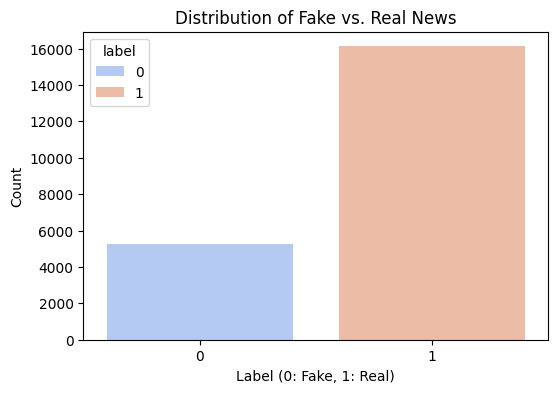

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data, hue='label', palette="coolwarm")
plt.title("Distribution of Fake vs. Real News")
plt.xlabel("Label (0: Fake, 1: Real)")
plt.ylabel("Count")
plt.show()

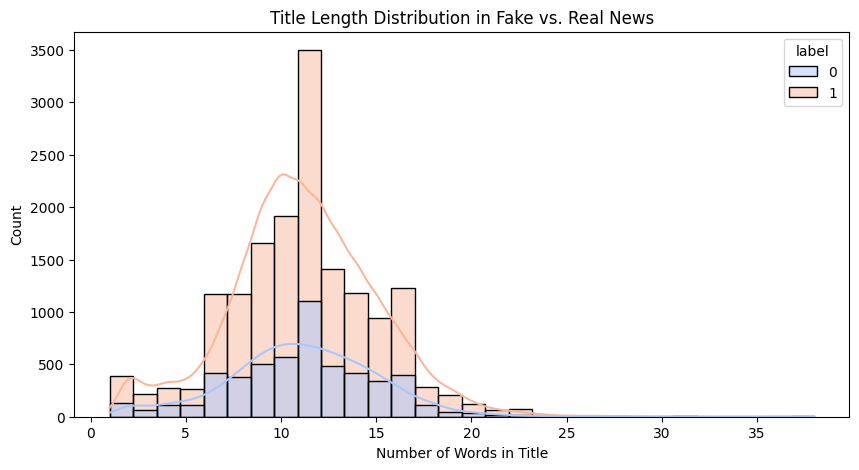

In [ ]:
data['title_length'] = data['title'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(data, x='title_length', hue='label', bins=30, kde=True, palette="coolwarm")
plt.title("Title Length Distribution in Fake vs. Real News")
plt.xlabel("Number of Words in Title")
plt.ylabel("Count")
plt.show()


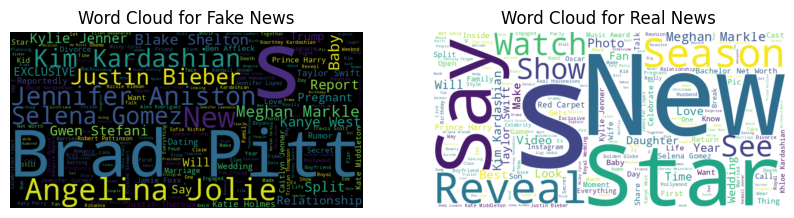

In [ ]:
from wordcloud import WordCloud

fake_text = " ".join(data[data['label'] == 0]['title'])
real_text = " ".join(data[data['label'] == 1]['title'])

wordcloud_fake = WordCloud(width=800, height=400, background_color="black").generate(fake_text)
wordcloud_real = WordCloud(width=800, height=400, background_color="white").generate(real_text)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Fake News")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Real News")

plt.show()

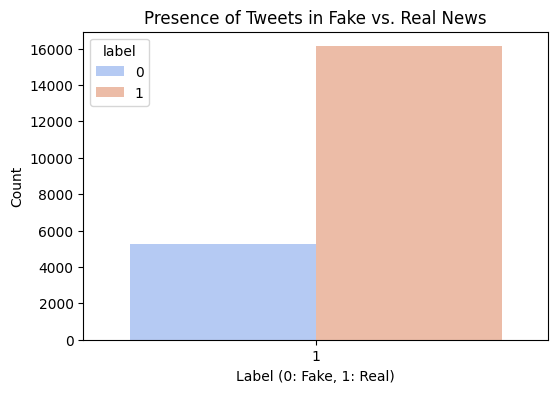

In [ ]:
data['has_tweet'] = data['tweet_ids'].notna().astype(int)

plt.figure(figsize=(6,4))
sns.countplot(x='has_tweet', hue='label', data=data, palette="coolwarm")
plt.title("Presence of Tweets in Fake vs. Real News")
plt.xlabel("Label (0: Fake, 1: Real)")
plt.ylabel("Count")
plt.show()

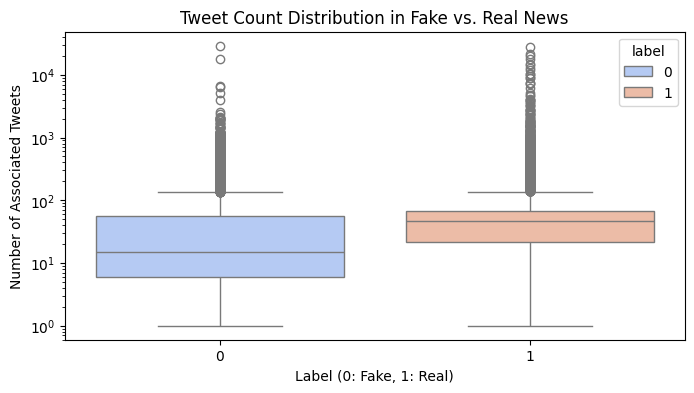

In [ ]:
data['num_tweets'] = data['tweet_ids'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

plt.figure(figsize=(8, 4))
sns.boxplot(x='label', y='num_tweets', data=data, palette="coolwarm", hue="label")
plt.title("Tweet Count Distribution in Fake vs. Real News")
plt.xlabel("Label (0: Fake, 1: Real)")
plt.ylabel("Number of Associated Tweets")
plt.yscale("log")
plt.show()

### Text Pre-processing

In [ ]:
data = data[['title', 'tweet_ids', 'label']]  # Keeping only relevant columns


In [ ]:
# Clean Text (Lowercase, Remove URLs, Special Characters, and Numbers)

import re

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters & numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['clean_title'] = data['title'].apply(clean_text)


In [ ]:
# Tokenization & Stopword Removal

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Stopword removal
    return ' '.join(tokens)

data['processed_title'] = data['clean_title'].apply(tokenize_and_remove_stopwords)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Lemmatization (Convert Words to Base Form)

from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

data['processed_title'] = data['processed_title'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Feature Extraction for Model Training

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_bert = tokenizer(data['processed_title'].tolist(), padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Prepare Data for Model Training

In [ ]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing titles
tokens = tokenizer(
    data['processed_title'].tolist(),
    padding=True, truncation=True,
    max_length=128, return_tensors="pt"
)

input_ids = tokens['input_ids']
attention_masks = tokens['attention_mask']
labels = torch.tensor(data['label'].values)

In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42
)
train_masks, val_masks, _, _ = train_test_split(
    attention_masks, labels, test_size=0.2, random_state=42
)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16  # Adjust based on available GPU memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### Fine-Tuning Transformer Models

In [ ]:
pip install transformers torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from transformers import RobertaForSequenceClassification, XLNetForSequenceClassification, DebertaForSequenceClassification
from transformers import AdamW

# Load models
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=2)

# Define optimizer
optimizer = AdamW(roberta_model.parameters(), lr=2e-5, eps=1e-8)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
import time
from tqdm import tqdm
from transformers import get_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_dataloader, val_dataloader, epochs=3):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs} Training...\n")
        model.train()
        total_loss, correct = 0, 0

        for batch in tqdm(train_dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            correct += (outputs.logits.argmax(1) == labels).sum().item()

        print(f"Train Loss: {total_loss/len(train_dataloader):.4f}, Accuracy: {correct/len(train_dataloader.dataset):.4f}")

        evaluate_model(model, val_dataloader)

def evaluate_model(model, val_dataloader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            correct += (outputs.logits.argmax(1) == labels).sum().item()

    print(f"Validation Accuracy: {correct/len(val_dataloader.dataset):.4f}")

In [ ]:
print("Training RoBERTa...")
train_model(roberta_model, train_dataloader, val_dataloader)

print("\nTraining XLNet...")
train_model(xlnet_model, train_dataloader, val_dataloader)

print("\nTraining DeBERTa...")
train_model(deberta_model, train_dataloader, val_dataloader)

Training RoBERTa...

Epoch 1/3 Training...



  0%|          | 0/1071 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

100%|██████████| 1071/1071 [02:35<00:00,  6.90it/s]


Train Loss: 0.5296, Accuracy: 0.7630
Validation Accuracy: 0.7996

Epoch 2/3 Training...



100%|██████████| 1071/1071 [02:28<00:00,  7.22it/s]


Train Loss: 0.4405, Accuracy: 0.8113
Validation Accuracy: 0.8083

Epoch 3/3 Training...



100%|██████████| 1071/1071 [02:28<00:00,  7.22it/s]


Train Loss: 0.3890, Accuracy: 0.8338
Validation Accuracy: 0.8094

Training XLNet...

Epoch 1/3 Training...



100%|██████████| 1071/1071 [02:40<00:00,  6.68it/s]


Train Loss: 0.5269, Accuracy: 0.7686
Validation Accuracy: 0.8115

Epoch 2/3 Training...



100%|██████████| 1071/1071 [02:39<00:00,  6.70it/s]


Train Loss: 0.4195, Accuracy: 0.8194
Validation Accuracy: 0.8312

Epoch 3/3 Training...



100%|██████████| 1071/1071 [02:39<00:00,  6.70it/s]


Train Loss: 0.3566, Accuracy: 0.8475
Validation Accuracy: 0.8312

Training DeBERTa...

Epoch 1/3 Training...



100%|██████████| 1071/1071 [02:56<00:00,  6.05it/s]


Train Loss: 0.5629, Accuracy: 0.7520
Validation Accuracy: 0.7539

Epoch 2/3 Training...



100%|██████████| 1071/1071 [02:56<00:00,  6.07it/s]


Train Loss: 0.5254, Accuracy: 0.7669
Validation Accuracy: 0.7987

Epoch 3/3 Training...



100%|██████████| 1071/1071 [02:57<00:00,  6.05it/s]


Train Loss: 0.4461, Accuracy: 0.8063
Validation Accuracy: 0.8031


In [ ]:
# Example training logs (Replace these with actual values)
epochs = [1, 2, 3]

# RoBERTa
roberta_train_loss = [0.5296, 0.4405, 0.3890]
roberta_train_acc = [0.7630, 0.8113, 0.8338]
roberta_val_acc = [0.7996, 0.8083, 0.8094]

# XLNet
xlnet_train_loss = [0.5269, 0.4195, 0.3566]
xlnet_train_acc = [0.7686, 0.8194, 0.8475]
xlnet_val_acc = [0.8115, 0.8312, 0.8312]

# DeBERTa
deberta_train_loss = [0.5629, 0.5254, 0.4461]
deberta_train_acc = [0.7520, 0.7669, 0.8063]
deberta_val_acc = [0.7539, 0.7987, 0.8031]

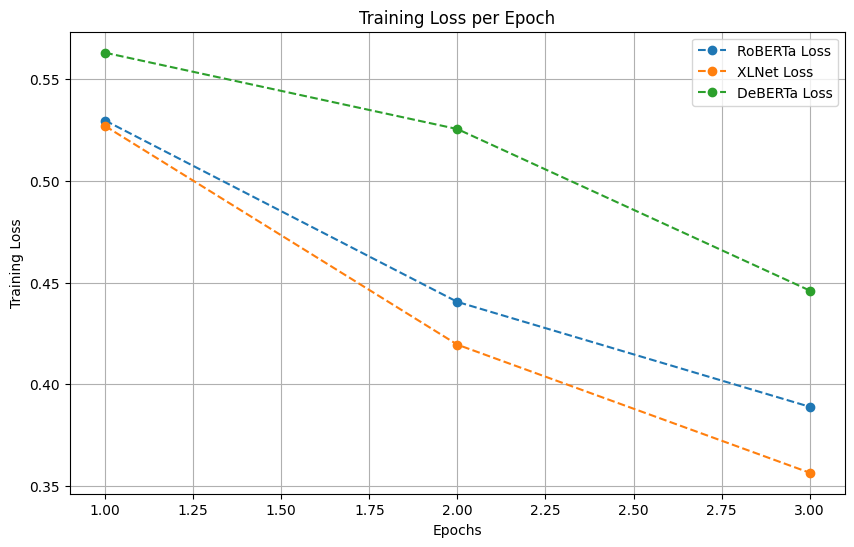

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot loss curves
plt.plot(epochs, roberta_train_loss, label="RoBERTa Loss", marker='o', linestyle='dashed')
plt.plot(epochs, xlnet_train_loss, label="XLNet Loss", marker='o', linestyle='dashed')
plt.plot(epochs, deberta_train_loss, label="DeBERTa Loss", marker='o', linestyle='dashed')

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

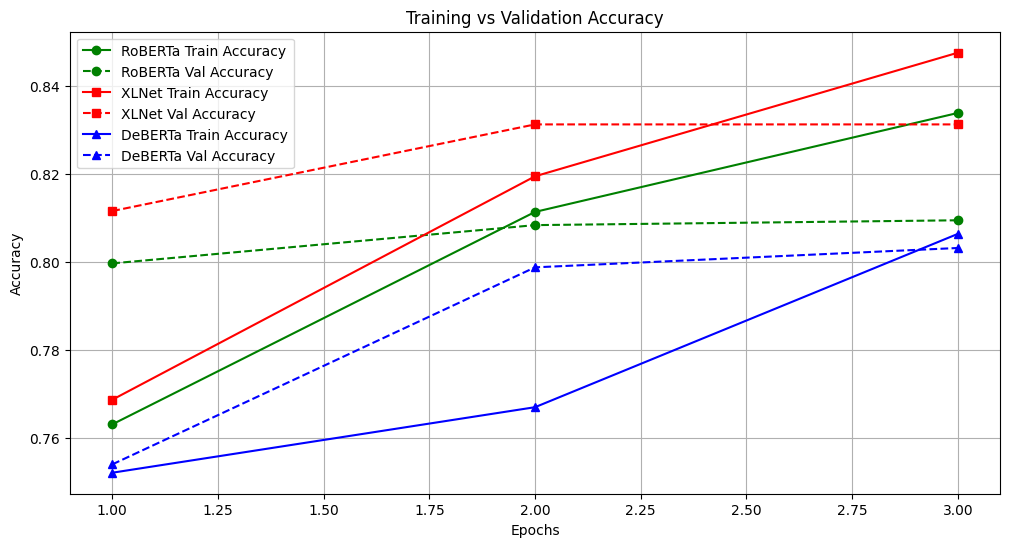

In [ ]:
plt.figure(figsize=(12, 6))

# RoBERTa
plt.plot(epochs, roberta_train_acc, label="RoBERTa Train Accuracy", marker='o', color = 'g')
plt.plot(epochs, roberta_val_acc, label="RoBERTa Val Accuracy", marker='o', linestyle='dashed', color = 'g')

# XLNet
plt.plot(epochs, xlnet_train_acc, label="XLNet Train Accuracy", marker='s', color = 'r')
plt.plot(epochs, xlnet_val_acc, label="XLNet Val Accuracy", marker='s', linestyle='dashed', color = 'r')

# DeBERTa
plt.plot(epochs, deberta_train_acc, label="DeBERTa Train Accuracy", marker='^', color = 'b')
plt.plot(epochs, deberta_val_acc, label="DeBERTa Val Accuracy", marker='^', linestyle='dashed', color = 'b')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Social Network Analysis (SNA)

In [ ]:
import networkx as nx

# Extract non-null tweet IDs
social_data = data.dropna(subset=["tweet_ids"])

social_data = social_data.copy()
social_data.loc[:, "tweet_ids"] = social_data["tweet_ids"].astype(str)

# Create a directed graph
G = nx.DiGraph()

for _, row in social_data.iterrows():
    tweet_ids = str(row["tweet_ids"]).split("\t")
    tweet_ids = [tid.strip() for tid in tweet_ids if tid.strip()]

    if len(tweet_ids) > 1:
        for i in range(len(tweet_ids) - 1):
            G.add_edge(tweet_ids[i], tweet_ids[i+1])

print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

Number of Nodes: 1907967
Number of Edges: 1900242


In [ ]:
# Calculate degree centrality
in_degree_centrality = nx.in_degree_centrality(G)   # Influence (receiving retweets)
out_degree_centrality = nx.out_degree_centrality(G)  # Activity (retweeting others)

# Sort the top 10 most influential users (highest in-degree centrality)
top_influencers = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Sort the top 10 most active users (highest out-degree centrality)
top_active_users = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Print results
print("🔹 Top 10 Influential Users (Most Retweeted)")
for user, score in top_influencers:
    print(f"User: {user}, In-Degree Centrality: {score:.5f}")

print("\n🔹 Top 10 Active Users (Most Retweeting)")
for user, score in top_active_users:
    print(f"User: {user}, Out-Degree Centrality: {score:.5f}")

🔹 Top 10 Influential Users (Most Retweeted)
User: 1050848952596291584, In-Degree Centrality: 0.00000
User: 1054082945714143233, In-Degree Centrality: 0.00000
User: 1039974769242898438, In-Degree Centrality: 0.00000
User: 1013817772999168001, In-Degree Centrality: 0.00000
User: 1053268942989348864, In-Degree Centrality: 0.00000
User: 996939321839153157, In-Degree Centrality: 0.00000
User: 1026165991590506502, In-Degree Centrality: 0.00000
User: 1031292920845029376, In-Degree Centrality: 0.00000
User: 1038336430504861696, In-Degree Centrality: 0.00000
User: 1052042712415899648, In-Degree Centrality: 0.00000

🔹 Top 10 Active Users (Most Retweeting)
User: 997294300940591104, Out-Degree Centrality: 0.00000
User: 1046915644791447552, Out-Degree Centrality: 0.00000
User: 955297222656131073, Out-Degree Centrality: 0.00000
User: 1036857390107250688, Out-Degree Centrality: 0.00000
User: 720824767754801153, Out-Degree Centrality: 0.00000
User: 1054082945714143233, Out-Degree Centrality: 0.00000
U

In [ ]:
from networkx.algorithms.structuralholes import constraint

# Compute structural hole constraint scores
constraint_scores = constraint(G)

# Find users with **low constraint** (most "exposed" to misinformation)
vulnerable_users = sorted(constraint_scores.items(), key=lambda x: x[1])[:10]

print("🔹 Top 10 Vulnerable Users (Most Likely to Believe Fake News):")
for user, score in vulnerable_users:
    print(f"User: {user}, Constraint Score: {score:.5f}")

🔹 Top 10 Vulnerable Users (Most Likely to Believe Fake News):
User: 1024169791857324032, Constraint Score: 0.16667
User: 1024367091615522826, Constraint Score: 0.16667
User: 1024486611587817473, Constraint Score: 0.16667
User: 1061009540391596032, Constraint Score: 0.16667
User: 1062568057879576576, Constraint Score: 0.16667
User: 1064719986961338369, Constraint Score: 0.16667
User: 1064928611352932355, Constraint Score: 0.16667
User: 1064289113321422850, Constraint Score: 0.16667
User: 1062521026645495808, Constraint Score: 0.21701
User: 1018479686261858304, Constraint Score: 0.25000


In [ ]:
# Compute PageRank (importance of nodes)
pagerank_scores = nx.pagerank(G)

In [ ]:
# Compute Betweenness Centrality (bridge nodes)
betweenness_scores = nx.betweenness_centrality(G)

KeyboardInterrupt: 

In [ ]:
# Sort and display top spreaders
top_spreaders = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Misinformation Spreaders:", top_spreaders)

Top Misinformation Spreaders: [('1054082945714143233', 1.8651641588437708e-06), ('1053268942989348864', 1.8651641588437708e-06), ('1048590737833488386', 1.6424139750093545e-06), ('1036652304521474049', 1.6424139750093545e-06), ('1032656980614234112', 1.6424139750093545e-06), ('1036857390107250688', 1.6424139750093545e-06), ('1036642044427554816', 1.6424139750093545e-06), ('1050848952596291584', 1.5681639137312155e-06), ('1039974769242898438', 1.5681639137312155e-06), ('1052042712415899648', 1.5681639137312155e-06)]


In [ ]:
# Compute degree centrality
degree_centrality = nx.degree_centrality(G)

# Identify potential bots (high out-degree, low in-degree)
bots = [node for node, score in degree_centrality.items() if G.out_degree(node) > 50 and G.in_degree(node) < 5]
print(f"Potential Bots Detected: {len(bots)}")

Potential Bots Detected: 0


In [ ]:
# Compute Eigenvector Centrality (influence score)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Find bots (high activity but low influence)
potential_bots = [
    (node, out_degree_centrality[node])
    for node in G.nodes()
    if out_degree_centrality[node] > 0.01 and eigenvector_centrality[node] < 0.001
]

# Sort by highest activity
potential_bots = sorted(potential_bots, key=lambda x: x[1], reverse=True)[:10]

print("🔹 Potential Bots (High Activity, Low Influence):")
for bot, score in potential_bots:
    print(f"User: {bot}, Activity Score: {score:.5f}")

🔹 Potential Bots (High Activity, Low Influence):


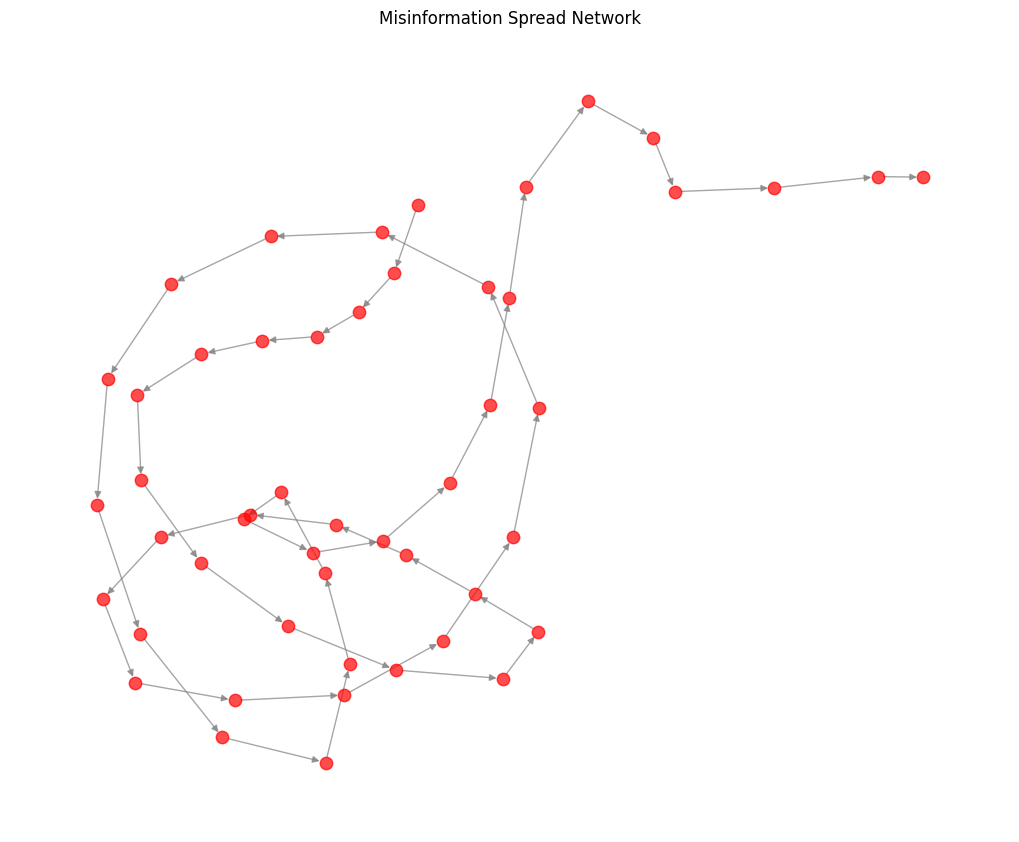

In [ ]:
import matplotlib.pyplot as plt

sub_G = G.subgraph(list(dict(pagerank_scores).keys())[:50])  # Top 50 influential nodes

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(sub_G, seed=42)

nx.draw(sub_G, pos, with_labels=False, node_size=80, node_color="red", edge_color="gray", alpha=0.7)
plt.title("Misinformation Spread Network")
plt.show()